In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('stock_data.csv')

In [57]:
data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Stock,moving_average
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL,NaN
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL,NaN
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL,NaN
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL,NaN
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL,NaN


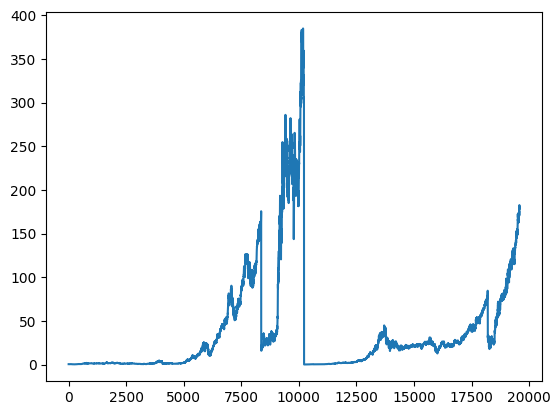

In [2]:
from matplotlib import pyplot as plt
plt.plot(data['Close'])
plt.show()

In [3]:
data["moving_average"] = data["Close"].rolling(10).mean()

<Axes: >

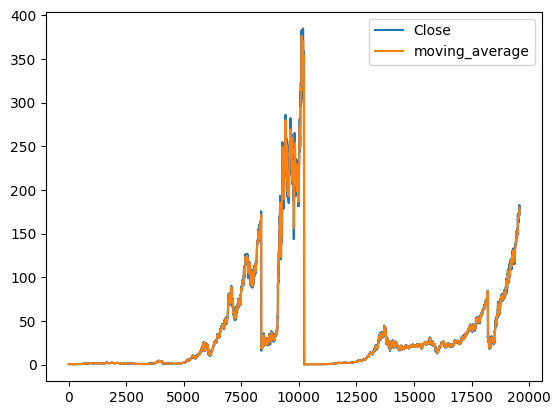

In [4]:
data[['Close','moving_average']].plot()

In [5]:
from sklearn.metrics import mean_squared_error

mean_squared_error(data["Close"][9:], data["moving_average"][9:])

24.8909653868925

In [ ]:
dataset_x = []
dataset_y = []
for i in range(0, data.shape[0]-31):
    # if data[i : i + 31].Close.shape[0] == 31:
    dataset_y.append(
        1
        if data[i : i + 30].Close.mean() < data.iloc[i + 30].Close
        else 0
    )
    mean_ = data[i : i + 30].Close.mean()
    std_ = data[i : i + 30].Close.std()
    dataset_x.append(list((data[i : i + 30].Close - mean_) / std_))

In [19]:
import numpy as np
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
dataset_x = dataset_x.reshape(dataset_x.shape[0],dataset_x.shape[1],1)

train_x, test_x = dataset_x[:3000], dataset_x[3000:]
train_y, test_y = dataset_y[:3000], dataset_y[3000:]
print(train_x.shape)
print(train_y.shape)

(3000, 30, 1)
(3000,)


In [ ]:
from tensorflow.keras import layers

def encoder(inputs, head_size, num_heads, feed_forward_dimension, dropout=0):
    # 确保输入是 3D 张量
    if len(inputs.shape) == 2:
        inputs = layers.Reshape((1, inputs.shape[-1]))(inputs)
    # Attention layer
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_result = x + inputs
    # Convlution as feedforward
    x = layers.Conv1D(filters=feed_forward_dimension, kernel_size=1, activation="relu")(
        attention_result
    )
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + attention_result

def build_model(input_shape, head_size, num_heads, ff_dim, dropout, num_transformer_blocks, dense_units, dense_dropout):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = encoder(x, head_size, num_heads, ff_dim, dropout)
        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for d in dense_units:
        x = layers.Dense(d, activation="relu")(x)
        x = layers.Dropout(dense_dropout)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
model = build_model(
    input_shape=train_x.shape[1:], 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    dropout=0.25,
    num_transformer_blocks=4,
    dense_units=[128],
    dense_dropout=0.4,
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 multi_head_attention_28 (M  (None, 30, 1)                7169      ['input_11[0][0]',            
 ultiHeadAttention)                                                  'input_11[0][0]']            
                                                                                                  
 dropout_51 (Dropout)        (None, 30, 1)                0         ['multi_head_attention_28[0][0
                                                                    ]']                           
                                                                                            

In [53]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

In [54]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [55]:
model.fit(
    train_x,
    train_y,
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
)


Epoch 1/5
94/94 [==============================] - 19s 13ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5603
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 0.6785 - sparse_categorical_accuracy: 0.7840
Epoch 3/5
94/94 [==============================] - 1s 13ms/step - loss: 0.6570 - sparse_categorical_accuracy: 0.8813
Epoch 4/5
94/94 [==============================] - 1s 12ms/step - loss: 0.6267 - sparse_categorical_accuracy: 0.9007
Epoch 5/5
94/94 [==============================] - 1s 13ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.9027


In [56]:
model.evaluate(test_x, test_y, verbose=1)

518/518 [==============================] - 3s 5ms/step - loss: 0.5554 - sparse_categorical_accuracy: 0.8860


[0.5554302930831909, 0.8859559297561646]